#### Importing libraries 

In [1]:
import cv2 # Import the OpenCV library to enable computer vision
import numpy as np # Import the NumPy scientific computing library
import edge_detection as edge # Handles the detection of lane lines
import matplotlib.pyplot as plt # Used for plotting and error checking
import jdc

In [2]:

class Lane:
  """
  Represents a lane on a road.
  """
  def __init__(self, orig_frame):
    """
      Default constructor
         
    :param orig_frame: Original camera image (i.e. frame)
    """
    self.orig_frame = orig_frame
 
    # This will hold an image with the lane lines       
    self.lane_line_markings = None
 
    # This will hold the image after perspective transformation
    self.warped_frame = None
    self.transformation_matrix = None
    self.inv_transformation_matrix = None
 
    # (Width, Height) of the original video frame (or image)
    self.orig_image_size = self.orig_frame.shape[::-1][1:]
 
    width = self.orig_image_size[0]
    height = self.orig_image_size[1]
    self.width = width
    self.height = height
     
    # Four corners of the trapezoid-shaped region of interest
    # You need to find these corners manually.
    self.roi_points = np.float32([
      (575,450), # Top-left corner
      (250, 700), # Bottom-left corner            
      (1150,700), # Bottom-right corner
      (735,450) # Top-right corner
    ])
         
    # The desired corner locations  of the region of interest
    # after we perform perspective transformation.
    # Assume image width of 600, padding == 150.
    self.padding = int(0.25 * width) # padding from side of the image in pixels
    self.desired_roi_points = np.float32([
      [self.padding, 0], # Top-left corner
      [self.padding, self.orig_image_size[1]], # Bottom-left corner         
      [self.orig_image_size[
        0]-self.padding, self.orig_image_size[1]], # Bottom-right corner
      [self.orig_image_size[0]-self.padding, 0] # Top-right corner
    ]) 
         
    # Histogram that shows the white pixel peaks for lane line detection
    self.histogram = None
         
    # Sliding window parameters
    self.no_of_windows = 10
    self.margin = int((1/12) * width)  # Window width is +/- margin
    self.minpix = int((1/24) * width)  # Min no. of pixels to recenter window
         
    # Best fit polynomial lines for left line and right line of the lane
    self.left_fit = None
    self.right_fit = None
    self.left_lane_inds = None
    self.right_lane_inds = None
    self.ploty = None
    self.left_fitx = None
    self.right_fitx = None
    self.leftx = None
    self.rightx = None
    self.lefty = None
    self.righty = None
         
    # Pixel parameters for x and y dimensions
    self.YM_PER_PIX = 10.0 / 1000 # meters per pixel in y dimension
    self.XM_PER_PIX = 3.7 / 781 # meters per pixel in x dimension
         
    # Radii of curvature and offset
    self.left_curvem = None
    self.right_curvem = None
    self.center_offset = None

In [3]:
%%add_to Lane
def calculate_car_position(self, print_to_terminal=False):
    """
    Calculate the position of the car relative to the center
         
    :param: print_to_terminal Display data to console if True       
    :return: Offset from the center of the lane
    """
    # Assume the camera is centered in the image.
    # Get position of car in centimeters
    car_location = self.orig_frame.shape[1] / 2
 
    # Fine the x coordinate of the lane line bottom
    height = self.orig_frame.shape[0]
    bottom_left = self.left_fit[0]*height**2 + self.left_fit[
      1]*height + self.left_fit[2]
    bottom_right = self.right_fit[0]*height**2 + self.right_fit[
      1]*height + self.right_fit[2]
 
    center_lane = (bottom_right - bottom_left)/2 + bottom_left 
    center_offset = (np.abs(car_location) - np.abs(
      center_lane)) * self.XM_PER_PIX * 100
 
    if print_to_terminal == True:
      print(str(center_offset) + 'cm')
             
    self.center_offset = center_offset
       
    return center_offset

In [4]:
%%add_to Lane
def calculate_curvature(self, print_to_terminal=False):
    """
    Calculate the road curvature in meters.
 
    :param: print_to_terminal Display data to console if True
    :return: Radii of curvature
    """
    # Set the y-value where we want to calculate the road curvature.
    # Select the maximum y-value, which is the bottom of the frame.
    y_eval = np.max(self.ploty)    
 
    # Fit polynomial curves to the real world environment
    left_fit_cr = np.polyfit(self.lefty * self.YM_PER_PIX, self.leftx * (
      self.XM_PER_PIX), 2)
    right_fit_cr = np.polyfit(self.righty * self.YM_PER_PIX, self.rightx * (
      self.XM_PER_PIX), 2)
             
    # Calculate the radii of curvature
    left_curvem = ((1 + (2*left_fit_cr[0]*y_eval*self.YM_PER_PIX + left_fit_cr[
                    1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvem = ((1 + (2*right_fit_cr[
                    0]*y_eval*self.YM_PER_PIX + right_fit_cr[
                    1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Display on terminal window
    if print_to_terminal == True:
      print(left_curvem, 'm', right_curvem, 'm')
             
    self.left_curvem = left_curvem
    self.right_curvem = right_curvem
 
    return left_curvem, right_curvem

In [5]:
%%add_to Lane
def calculate_histogram(self,frame=None,plot=True):
    """
    Calculate the image histogram to find peaks in white pixel count
         
    :param frame: The warped image
    :param plot: Create a plot if True
    """
    if frame is None:
      frame = self.warped_frame
             
    # Generate the histogram
    self.histogram = np.sum(frame[int(
              frame.shape[0]/2):,:], axis=0)
 
    if plot == True:
         
      # Draw both the image and the histogram
      figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
      figure.set_size_inches(10, 5)
      ax1.imshow(frame, cmap='gray')
      ax1.set_title("Warped Binary Frame")
      ax2.plot(self.histogram)
      ax2.set_title("Histogram Peaks")
      plt.show()
             
    return self.histogram

In [6]:
%%add_to Lane
def display_curvature_offset(self, frame=None, plot=False):
    """
    Display curvature and offset statistics on the image
         
    :param: plot Display the plot if True
    :return: Image with lane lines and curvature
    """
    image_copy = None
    if frame is None:
      image_copy = self.orig_frame.copy()
    else:
      image_copy = frame
 
    cv2.putText(image_copy,'Curve Radius: '+str((
      self.left_curvem+self.right_curvem)/2)[:7]+' m', (int((
      5/600)*self.width), int((
      20/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, (float((
      0.5/600)*self.width)),(
      255,255,255),2,cv2.LINE_AA)
    cv2.putText(image_copy,'Center Offset: '+str(
      self.center_offset)[:7]+' cm', (int((
      5/600)*self.width), int((
      40/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, (float((
      0.5/600)*self.width)),(
      255,255,255),2,cv2.LINE_AA)
             
    if plot==True:       
      cv2.imshow("Image with Curvature and Offset", image_copy)
      cv2.waitKey(0)
 
    return image_copy

In [7]:
%%add_to Lane
def get_lane_line_previous_window(self, left_fit, right_fit, plot=False):
    """
    Use the lane line from the previous sliding window to get the parameters
    for the polynomial line for filling in the lane line
    :param: left_fit Polynomial function of the left lane line
    :param: right_fit Polynomial function of the right lane line
    :param: plot To display an image or not
    """
    # margin is a sliding window parameter
    margin = self.margin
 
    # Find the x and y coordinates of all the nonzero 
    # (i.e. white) pixels in the frame.         
    nonzero = self.warped_frame.nonzero()  
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
         
    # Store left and right lane pixel indices
    left_lane_inds = ((nonzerox > (left_fit[0]*(
      nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (
      nonzerox < (left_fit[0]*(
      nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(
      nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (
      nonzerox < (right_fit[0]*(
      nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))           
    self.left_lane_inds = left_lane_inds
    self.right_lane_inds = right_lane_inds
 
    # Get the left and right lane line pixel locations  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  
 
    self.leftx = leftx
    self.rightx = rightx
    self.lefty = lefty
    self.righty = righty        
     
    # Fit a second order polynomial curve to each lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    self.left_fit = left_fit
    self.right_fit = right_fit
         
    # Create the x and y values to plot on the image
    ploty = np.linspace(
      0, self.warped_frame.shape[0]-1, self.warped_frame.shape[0]) 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    self.ploty = ploty
    self.left_fitx = left_fitx
    self.right_fitx = right_fitx
         
    if plot==True:
         
      # Generate images to draw on
      out_img = np.dstack((self.warped_frame, self.warped_frame, (
                           self.warped_frame)))*255
      window_img = np.zeros_like(out_img)
             
      # Add color to the left and right line pixels
      out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
      out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [
                                                                     0, 0, 255]
      # Create a polygon to show the search window area, and recast 
      # the x and y points into a usable format for cv2.fillPoly()
      margin = self.margin
      left_line_window1 = np.array([np.transpose(np.vstack([
                                    left_fitx-margin, ploty]))])
      left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([
                                    left_fitx+margin, ploty])))])
      left_line_pts = np.hstack((left_line_window1, left_line_window2))
      right_line_window1 = np.array([np.transpose(np.vstack([
                                     right_fitx-margin, ploty]))])
      right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([
                                     right_fitx+margin, ploty])))])
      right_line_pts = np.hstack((right_line_window1, right_line_window2))
             
      # Draw the lane onto the warped blank image
      cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
      cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
      result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
       
      # Plot the figures 
      figure, (ax1, ax2, ax3) = plt.subplots(3,1) # 3 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
      ax1.imshow(cv2.cvtColor(self.orig_frame, cv2.COLOR_BGR2RGB))
      ax2.imshow(self.warped_frame, cmap='gray')
      ax3.imshow(result)
      ax3.plot(left_fitx, ploty, color='yellow')
      ax3.plot(right_fitx, ploty, color='yellow')
      ax1.set_title("Original Frame")  
      ax2.set_title("Warped Frame")
      ax3.set_title("Warped Frame With Search Window")
      plt.show()

In [8]:
%%add_to Lane
def get_lane_line_indices_sliding_windows(self, plot=False):
    """
    Get the indices of the lane line pixels using the 
    sliding windows technique.
         
    :param: plot Show plot or not
    :return: Best fit lines for the left and right lines of the current lane 
    """
    # Sliding window width is +/- margin
    margin = self.margin
 
    frame_sliding_window = self.warped_frame.copy()
 
    # Set the height of the sliding windows
    window_height = np.int(self.warped_frame.shape[0]/self.no_of_windows)       
 
    # Find the x and y coordinates of all the nonzero 
    # (i.e. white) pixels in the frame. 
    nonzero = self.warped_frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1]) 
         
    # Store the pixel indices for the left and right lane lines
    left_lane_inds = []
    right_lane_inds = []
         
    # Current positions for pixel indices for each window,
    # which we will continue to update
    leftx_base, rightx_base = self.histogram_peak()
    leftx_current = leftx_base
    rightx_current = rightx_base
 
    # Go through one window at a time
    no_of_windows = self.no_of_windows
         
    for window in range(no_of_windows):
       
      # Identify window boundaries in x and y (and right and left)
      win_y_low = self.warped_frame.shape[0] - (window + 1) * window_height
      win_y_high = self.warped_frame.shape[0] - window * window_height
      win_xleft_low = leftx_current - margin
      win_xleft_high = leftx_current + margin
      win_xright_low = rightx_current - margin
      win_xright_high = rightx_current + margin
      cv2.rectangle(frame_sliding_window,(win_xleft_low,win_y_low),(
        win_xleft_high,win_y_high), (255,255,255), 2)
      cv2.rectangle(frame_sliding_window,(win_xright_low,win_y_low),(
        win_xright_high,win_y_high), (255,255,255), 2)
 
      # Identify the nonzero pixels in x and y within the window
      good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (
                           nonzerox < win_xleft_high)).nonzero()[0]
      good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (
                            nonzerox < win_xright_high)).nonzero()[0]
                                                         
      # Append these indices to the lists
      left_lane_inds.append(good_left_inds)
      right_lane_inds.append(good_right_inds)
         
      # If you found > minpix pixels, recenter next window on mean position
      minpix = self.minpix
      if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
      if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                     
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
 
    # Extract the pixel coordinates for the left and right lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds] 
    righty = nonzeroy[right_lane_inds]
 
    # Fit a second order polynomial curve to the pixel coordinates for
    # the left and right lane lines
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
         
    self.left_fit = left_fit
    self.right_fit = right_fit
 
    if plot==True:
         
      # Create the x and y values to plot on the image  
      ploty = np.linspace(
        0, frame_sliding_window.shape[0]-1, frame_sliding_window.shape[0])
      left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
      right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
      # Generate an image to visualize the result
      out_img = np.dstack((
        frame_sliding_window, frame_sliding_window, (
        frame_sliding_window))) * 255
             
      # Add color to the left line pixels and right line pixels
      out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
      out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [
        0, 0, 255]
                 
      # Plot the figure with the sliding windows
      figure, (ax1, ax2, ax3) = plt.subplots(3,1) # 3 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
      ax1.imshow(cv2.cvtColor(self.orig_frame, cv2.COLOR_BGR2RGB))
      ax2.imshow(frame_sliding_window, cmap='gray')
      ax3.imshow(out_img)
      ax3.plot(left_fitx, ploty, color='yellow')
      ax3.plot(right_fitx, ploty, color='yellow')
      ax1.set_title("Original Frame")  
      ax2.set_title("Warped Frame with Sliding Windows")
      ax3.set_title("Detected Lane Lines with Sliding Windows")
      plt.show()        
             
    return self.left_fit, self.right_fit

In [9]:
%%add_to Lane
def get_line_markings(self, frame=None):
    """
    Isolates lane lines.
   
      :param frame: The camera frame that contains the lanes we want to detect
    :return: Binary (i.e. black and white) image containing the lane lines.
    """
    if frame is None:
      frame = self.orig_frame
             
    # Convert the video frame from BGR (blue, green, red) 
    # color space to HLS (hue, saturation, lightness).
    hls = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)
 
    ################### Isolate possible lane line edges ######################
         
    # Perform Sobel edge detection on the L (lightness) channel of 
    # the image to detect sharp discontinuities in the pixel intensities 
    # along the x and y axis of the video frame.             
    # sxbinary is a matrix full of 0s (black) and 255 (white) intensity values
    # Relatively light pixels get made white. Dark pixels get made black.
    _, sxbinary = edge.threshold(hls[:, :, 1], thresh=(120, 255))
    sxbinary = edge.blur_gaussian(sxbinary, ksize=3) # Reduce noise
         
    # 1s will be in the cells with the highest Sobel derivative values
    # (i.e. strongest lane line edges)
    sxbinary = edge.mag_thresh(sxbinary, sobel_kernel=3, thresh=(110, 255))
 
    ######################## Isolate possible lane lines ######################
   
    # Perform binary thresholding on the S (saturation) channel 
    # of the video frame. A high saturation value means the hue color is pure.
    # We expect lane lines to be nice, pure colors (i.e. solid white, yellow)
    # and have high saturation channel values.
    # s_binary is matrix full of 0s (black) and 255 (white) intensity values
    # White in the regions with the purest hue colors (e.g. >80...play with
    # this value for best results).
    s_channel = hls[:, :, 2] # use only the saturation channel data
    _, s_binary = edge.threshold(s_channel, (80, 255))
     
    # Perform binary thresholding on the R (red) channel of the 
        # original BGR video frame. 
    # r_thresh is a matrix full of 0s (black) and 255 (white) intensity values
    # White in the regions with the richest red channel values (e.g. >120).
    # Remember, pure white is bgr(255, 255, 255).
    # Pure yellow is bgr(0, 255, 255). Both have high red channel values.
    _, r_thresh = edge.threshold(frame[:, :, 2], thresh=(120, 255))
 
    # Lane lines should be pure in color and have high red channel values 
    # Bitwise AND operation to reduce noise and black-out any pixels that
    # don't appear to be nice, pure, solid colors (like white or yellow lane 
    # lines.)       
    rs_binary = cv2.bitwise_and(s_binary, r_thresh)
 
    ### Combine the possible lane lines with the possible lane line edges ##### 
    # If you show rs_binary visually, you'll see that it is not that different 
    # from this return value. The edges of lane lines are thin lines of pixels.
    self.lane_line_markings = cv2.bitwise_or(rs_binary, sxbinary.astype(
                              np.uint8))    
    return self.lane_line_markings

In [10]:
%%add_to Lane
def histogram_peak(self):
    """
    Get the left and right peak of the histogram
 
    Return the x coordinate of the left histogram peak and the right histogram
    peak.
    """
    midpoint = np.int(self.histogram.shape[0]/2)
    leftx_base = np.argmax(self.histogram[:midpoint])
    rightx_base = np.argmax(self.histogram[midpoint:]) + midpoint
 
    # (x coordinate of left peak, x coordinate of right peak)
    return leftx_base, rightx_base

In [11]:
%%add_to Lane
def overlay_lane_lines(self, plot=False):
    """
    Overlay lane lines on the original frame
    :param: Plot the lane lines if True
    :return: Lane with overlay
    """
    # Generate an image to draw the lane lines on 
    warp_zero = np.zeros_like(self.warped_frame).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))       
         
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([
                         self.left_fitx, self.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([
                          self.right_fitx, self.ploty])))])
    pts = np.hstack((pts_left, pts_right))
         
    # Draw lane on the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
 
    # Warp the blank back to original image space using inverse perspective 
    # matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, self.inv_transformation_matrix, (
                                  self.orig_frame.shape[
                                  1], self.orig_frame.shape[0]))
     
    # Combine the result with the original image
    result = cv2.addWeighted(self.orig_frame, 1, newwarp, 0.3, 0)
         
    if plot==True:
      
      # Plot the figures 
      figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
      ax1.imshow(cv2.cvtColor(self.orig_frame, cv2.COLOR_BGR2RGB))
      ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
      ax1.set_title("Original Frame")  
      ax2.set_title("Original Frame With Lane Overlay")
      plt.show()   
 
    return result 

In [12]:
%%add_to Lane
def perspective_transform(self, frame=None, plot=False):
    """
    Perform the perspective transform.
    :param: frame Current frame
    :param: plot Plot the warped image if True
    :return: Bird's eye view of the current lane
    """
    if frame is None:
      frame = self.lane_line_markings
             
    # Calculate the transformation matrix
    self.transformation_matrix = cv2.getPerspectiveTransform(
      self.roi_points, self.desired_roi_points)
 
    # Calculate the inverse transformation matrix           
    self.inv_transformation_matrix = cv2.getPerspectiveTransform(
      self.desired_roi_points, self.roi_points)
 
    # Perform the transform using the transformation matrix
    self.warped_frame = cv2.warpPerspective(
      frame, self.transformation_matrix, self.orig_image_size, flags=(
     cv2.INTER_LINEAR)) 
 
    # Convert image to binary
    (thresh, binary_warped) = cv2.threshold(
      self.warped_frame, 127, 255, cv2.THRESH_BINARY)           
    self.warped_frame = binary_warped
 
    # Display the perspective transformed (i.e. warped) frame
    if plot == True:
      warped_copy = self.warped_frame.copy()
      warped_plot = cv2.polylines(warped_copy, np.int32([
                    self.desired_roi_points]), True, (147,20,255), 3)
 
      # Display the image
      while(1):
        cv2.imshow('Warped Image', warped_plot)
             
        # Press any key to stop
        if cv2.waitKey(0):
          break
 
      cv2.destroyAllWindows()   
             
    return self.warped_frame 

In [13]:
%%add_to Lane
def plot_roi(self, frame=None, plot=False):
    """
    Plot the region of interest on an image.
    :param: frame The current image frame
    :param: plot Plot the roi image if True
    """
    if plot == False:
      return
             
    if frame is None:
      frame = self.orig_frame.copy()
 
    # Overlay trapezoid on the frame
    this_image = cv2.polylines(frame, np.int32([
      self.roi_points]), True, (147,20,255), 3)
 
    # Display the image
    while(1):
      cv2.imshow('ROI Image', this_image)
             
      # Press any key to stop
      if cv2.waitKey(0):
        break
 
    cv2.destroyAllWindows()

In [14]:
# Load a frame (or image)
filedir = 'Project_data/test_images/test1.jpg'  
original_frame = cv2.imread(filedir)
cv2.imshow('image', original_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
# Create a Lane object
lane_obj = Lane(orig_frame=original_frame)
 
# Perform thresholding to isolate lane lines
lane_line_markings = lane_obj.get_line_markings()
 
# Plot the region of interest on the image
lane_obj.plot_roi(plot=True)

In [16]:
# Perform the perspective transform to generate a bird's eye view
# If Plot == True, show image with new region of interest
warped_frame = lane_obj.perspective_transform(plot=True)

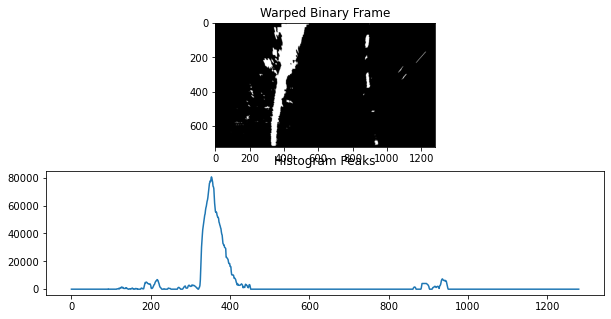

In [17]:
# Generate the image histogram to serve as a starting point
# for finding lane line pixels
histogram = lane_obj.calculate_histogram(plot=True)

<string>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

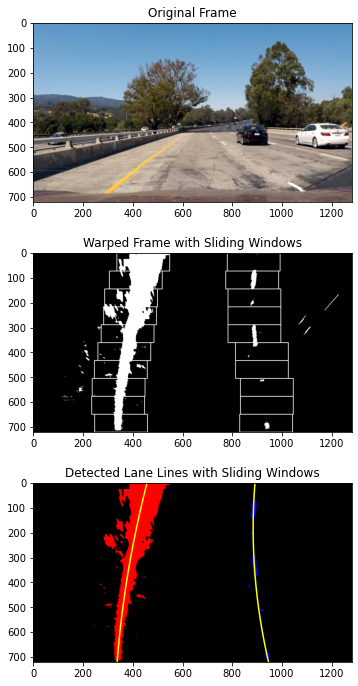

In [18]:
# Find lane line pixels using the sliding window method 
left_fit, right_fit = lane_obj.get_lane_line_indices_sliding_windows(
    plot=True)

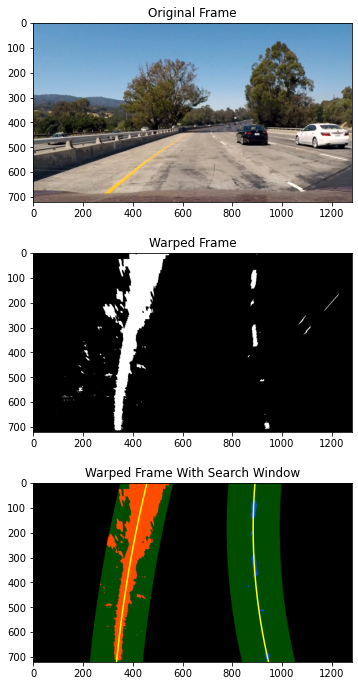

In [19]:
# Fill in the lane line
lane_obj.get_lane_line_previous_window(left_fit, right_fit, plot=True)

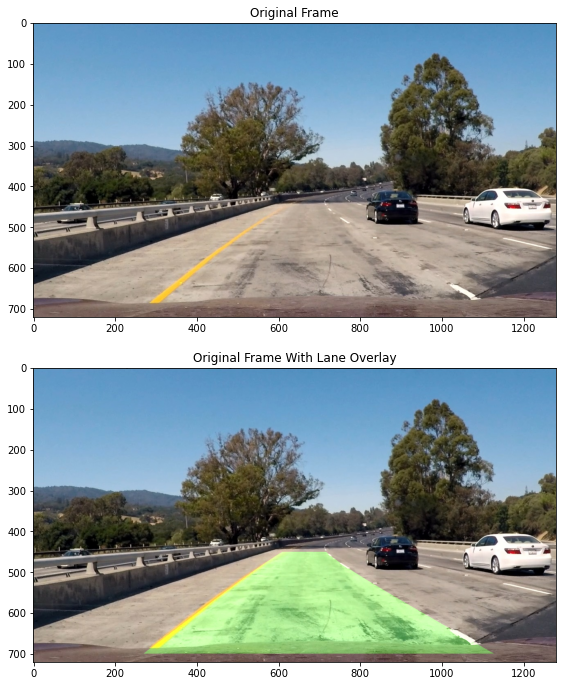

In [20]:
# Overlay lines on the original frame
frame_with_lane_lines = lane_obj.overlay_lane_lines(plot=True)

In [21]:
# Calculate lane line curvature (left and right lane lines)
lane_obj.calculate_curvature(print_to_terminal=True)

105.6716709695993 m 49.89234179994504 m


(105.6716709695993, 49.89234179994504)

In [22]:
# Calculate center offset                                                                 
lane_obj.calculate_car_position(print_to_terminal=True)

0.04845737536931121cm


0.04845737536931121

In [23]:
# Display curvature and center offset on image
frame_with_lane_lines2 = lane_obj.display_curvature_offset(frame=frame_with_lane_lines, plot=True)

In [24]:
# Create the output file name by removing the '.jpg' part
size = len(filedir)
new_filename = filedir[:size - 4]
new_filename = new_filename + '_thresholded.jpg'     
     
# Save the new image in the working directory
cv2.imwrite(new_filename, frame_with_lane_lines)
# Display the image 
cv2.imshow("Image", frame_with_lane_lines) 
# Display the window until any key is pressed
cv2.waitKey(0)     
# Close all windows
cv2.destroyAllWindows() 